# Differential Analysis with Log Transformation: Wild Type vs. Mutants

This notebook performs differential analysis to identify EfficientNet-derived features that differ significantly between wild type (WT) and mutants, addressing the issue of p-values being exactly zero.

**Data**: Preprocessed bacterial data with 1,280 features, label (0=WT, 1=mutant), batch, group, area, and image_path.

**Method**:
- Log transformation to handle small mean values and stabilize variance.
- Two-sample t-test (Welch’s) and Mann-Whitney U test with Benjamini-Hochberg FDR correction.
- Cohen’s d and rank-biserial correlation for effect sizes.
- Diagnostics for sample size, normality, and batch effects.

**Outputs**: Tables, volcano plots, Q-Q plots, PCA plots, saved in `/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/`.

In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm

# Set plot style
sns.set_style('whitegrid')

# Create results directory
os.makedirs('/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/', exist_ok=True)

## Load and Prepare Data

Load feature and area data and merge.

In [18]:
raw_df = pd.read_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/patches3/patches3_rmsprop_features.csv')
area_df = pd.read_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/patches3/patches_cell_areas.csv')
raw_df = pd.merge(raw_df, area_df, on='image_path', how='inner')
print(f'DataFrame shape: {raw_df.shape}')

DataFrame shape: (26600, 1282)


In [19]:
raw_df.head(1)

,image_path,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,area
0,/scratch/leuven/359/vsc35907/feature_extractio...,-0.000015,0.000041,0.000361,-0.000913,0.001696,0.000002,-0.001157,-0.044952,-0.00002,...,-0.000253,-0.000018,-0.000092,0.011581,0.000905,-0.004547,0.000018,-0.000253,-0.001631,620


## Add Metadata Columns

Add label, batch, and group columns based on image_path.

In [20]:
def extract_batch(path):
    return int(os.path.basename(path).split()[0][:-3])

def extract_group(path):
    basename = os.path.basename(path)
    directory = os.path.dirname(path)
    if 'mutants' in directory:
        return int(basename.split()[3])
    else:
        return int(basename.split()[2])

raw_df['label'] = raw_df['image_path'].apply(lambda x: 1 if 'mutant' in x.lower() else 0)
raw_df['batch'] = raw_df['image_path'].apply(extract_batch)
raw_df['group'] = raw_df['image_path'].apply(extract_group)

# Move 'image_path' to the end
first_column = raw_df.iloc[:, 0].name
raw_df = raw_df[[col for col in raw_df.columns if col != first_column] + [first_column]]
print(raw_df.columns)

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       ...
       'feature_1275', 'feature_1276', 'feature_1277', 'feature_1278',
       'feature_1279', 'area', 'label', 'batch', 'group', 'image_path'],
      dtype='object', length=1285)


## Data Cleaning

Remove columns with one unique value and filter cells with area < 270.

In [21]:
feature_columns = [col for col in raw_df.columns if col.startswith('feature_')]
column_names = [col for col in feature_columns if len(raw_df[col].unique()) == 1]
raw_df = raw_df.drop(columns=column_names)
feature_columns = [col for col in feature_columns if col not in column_names]
print(f'Removed {len(column_names)} columns with one unique value')

print('Area before filtering:')
print(raw_df.area.describe())
raw_df = raw_df[raw_df['area'] >= 270]
print('Area after filtering:')
print(raw_df.area.describe())

Removed 158 columns with one unique value
Area before filtering:
count    26600.000000
mean       513.643308
std        135.906423
min         15.000000
25%        418.000000
50%        494.000000
75%        599.000000
max       1529.000000
Name: area, dtype: float64
Area after filtering:
count    26230.000000
mean       518.581624
std        129.854251
min        270.000000
25%        421.000000
50%        496.000000
75%        601.000000
max       1529.000000
Name: area, dtype: float64


## Outlier Detection

Remove outliers using z-score thresholding.

In [22]:
def filter_outliers_zscore(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    inlier_mask = (z_scores < threshold).all(axis=1)
    return df[inlier_mask], df[~inlier_mask]

df, df_outliers = filter_outliers_zscore(raw_df[feature_columns], threshold=9)
df = df.assign(**{col: raw_df.loc[df.index, col] for col in ['area', 'label', 'batch', 'group', 'image_path']})
df_outliers = df_outliers.assign(**{col: raw_df.loc[df_outliers.index, col] for col in ['area', 'label', 'batch', 'group', 'image_path']})
print(f'Cleaned DataFrame shape: {df.shape}')
print(f'Outliers DataFrame shape: {df_outliers.shape}')

Cleaned DataFrame shape: (25771, 1127)
Outliers DataFrame shape: (459, 1127)


## Sample Size Check

Verify sample sizes for WT and mutant groups.

In [23]:
wt_count = df[df['label'] == 0].shape[0]
mutant_count = df[df['label'] == 1].shape[0]
print(f'Wild type samples: {wt_count}')
print(f'Mutant samples: {mutant_count}')
print(f'Total samples: {df.shape[0]}')
if wt_count > 10000 or mutant_count > 10000:
    print('Warning: Large sample sizes may lead to very small p-values even for small differences.')
else:
    print('Sample sizes are reasonable, but verify effect sizes for practical significance.')

Wild type samples: 13001
Mutant samples: 12770
Total samples: 25771


## Log Transformation and Standardization

Apply log transformation to handle small means, followed by standardization.

In [24]:
df_scaled = df.copy()
for col in feature_columns:
    if (df[col] < 0).any():
        df_scaled[col] = np.log1p(df[col] - df[col].min() + 1)
    else:
        df_scaled[col] = np.log1p(df[col])
        
scaler = StandardScaler()
df_scaled[feature_columns] = scaler.fit_transform(df_scaled[feature_columns])
print(df_scaled[feature_columns[0]].describe())

count    2.577100e+04
mean    -6.965830e-09
std      1.000019e+00
min     -2.726332e-01
25%     -2.726332e-01
50%     -2.726332e-01
75%     -2.726332e-01
max      3.667933e+00
Name: feature_1, dtype: float64


In [25]:
df_scaled.head(2)

,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,feature_12,feature_13,...,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,area,label,batch,group,image_path
0,-0.272633,0.989251,-1.471605,1.273993,-0.735781,-1.084953,-6.630252e-13,-1.345636,-0.958659,1.326945,...,-0.804659,-1.202278,-0.985547,-8.832934e-13,0.876336,620,1,190423,3,/scratch/leuven/359/vsc35907/feature_extractio...
1,-0.272633,0.821968,-0.571317,0.224794,-0.789116,-0.825195,-6.630252e-13,-0.751996,-0.821917,0.784881,...,-0.801155,-0.653534,-0.822064,-8.832934e-13,0.811122,406,1,190423,4,/scratch/leuven/359/vsc35907/feature_extractio...


## Normality Check
### Split data into wild type and mutant groups

In [26]:
wt_df = df_scaled[df_scaled['label'] == 0]
mutant_df = df_scaled[df_scaled['label'] == 1]

In [27]:
# Define function for Shapiro-Wilk test on subsample
def shapiro_subsample(data, subsample_size=500):
    if len(data) > subsample_size:
        subsample = np.random.choice(data, subsample_size, replace=False)
    else:
        subsample = data
    stat, p = shapiro(subsample)
    return p

In [28]:
# Classify features based on normality in both groups
normal_features = []
non_normal_features = []
for feature in feature_columns:
    p_wt = shapiro_subsample(wt_df[feature].values)
    p_mutant = shapiro_subsample(mutant_df[feature].values)
    if p_wt > 0.05 and p_mutant > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f'Number of features normally distributed in both groups: {len(normal_features)}')
print(f'Number of features not normally distributed in at least one group: {len(non_normal_features)}')

/data/leuven/359/vsc35907/miniconda3/envs/omnipose/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Number of features normally distributed in both groups: 26
Number of features not normally distributed in at least one group: 1096


In [29]:
print(normal_features)

['feature_128', 'feature_193', 'feature_207', 'feature_250', 'feature_260', 'feature_286', 'feature_300', 'feature_336', 'feature_442', 'feature_445', 'feature_581', 'feature_623', 'feature_645', 'feature_660', 'feature_725', 'feature_755', 'feature_777', 'feature_794', 'feature_856', 'feature_890', 'feature_910', 'feature_929', 'feature_948', 'feature_1031', 'feature_1080', 'feature_1089']


In [15]:
# Define Cohen's d function
def cohen_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    return (np.mean(x1) - np.mean(x2)) / pooled_std

In [16]:
# Differential analysis with appropriate test based on normality
results = []
for feature in feature_columns:
    group1 = wt_df[feature]
    group2 = mutant_df[feature]
    if feature in normal_features:
        stat, pval = ttest_ind(group1, group2, equal_var=False)
        effect_size = cohen_d(group1, group2)
        test_used = 'ttest'
    else:
        stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')
        u = stat
        n1, n2 = len(group1), len(group2)
        effect_size = 1 - (2 * u) / (n1 * n2)  # rank-biserial correlation
        test_used = 'mwu'
    results.append({
        'feature': feature,
        'test_used': test_used,
        'stat': stat,
        'p_value': pval,
        'effect_size': effect_size
    })

results_df = pd.DataFrame(results)
# Apply FDR correction
results_df['fdr_p'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
# Sort by absolute effect size
results_df = results_df.sort_values(by='effect_size', key=abs, ascending=False)
print('Differential analysis results:')
print(results_df.head())
# Save to CSV
results_df.to_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/differential_results.csv', index=False)

/tmp/ipykernel_2125480/3458022525.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return (np.mean(x1) - np.mean(x2)) / pooled_std
/data/leuven/359/vsc35907/miniconda3/envs/omnipose/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Differential analysis results:
         feature test_used       stat  p_value  effect_size  fdr_p
848  feature_967       mwu  4791461.0      0.0     0.942279    NaN
655  feature_752       mwu  4801744.0      0.0     0.942156    NaN
806  feature_917       mwu  4808843.0      0.0     0.942070    NaN
514  feature_591       mwu  4809756.0      0.0     0.942059    NaN
542  feature_622       mwu  4819917.0      0.0     0.941937    NaN


In [15]:
# Summary of significant features
significant_ttest = results_df[(results_df['test_used'] == 'ttest') & (results_df['fdr_p'] < 0.05)]
significant_mwu = results_df[(results_df['test_used'] == 'mwu') & (results_df['fdr_p'] < 0.05)]
print(f'Number of significant features with t-test: {len(significant_ttest)}')
print(f'Number of significant features with Mann-Whitney U: {len(significant_mwu)}')

Number of significant features with t-test: 0
Number of significant features with Mann-Whitney U: 0


Text(0, 0.5, '-log10(FDR p-value)')

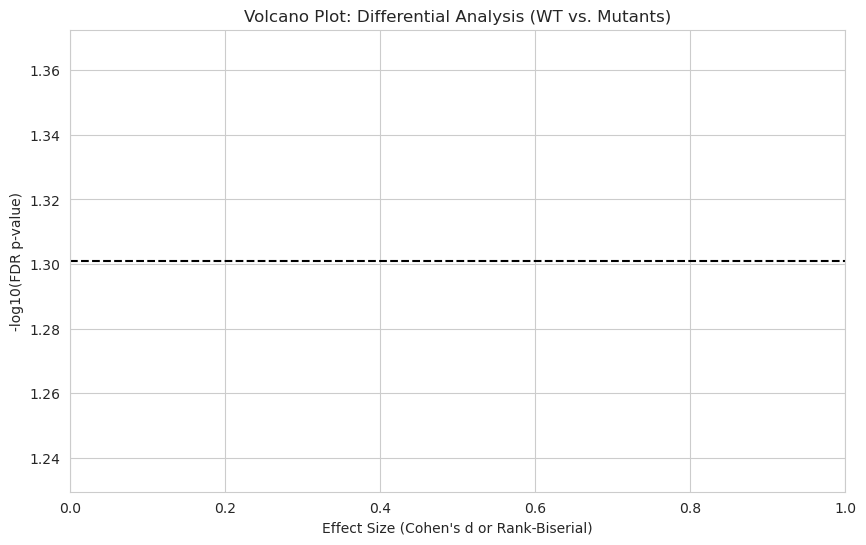

In [18]:
# Visualization: Volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='effect_size', y=-np.log10(results_df['fdr_p']), hue='test_used', palette={'ttest': 'blue', 'mwu': 'green'}, alpha=0.6)
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.title('Volcano Plot: Differential Analysis (WT vs. Mutants)')
plt.xlabel('Effect Size (Cohen\'s d or Rank-Biserial)')
plt.ylabel('-log10(FDR p-value)')
# plt.savefig('/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/volcano_combined.png')
# plt.close()

In [17]:
# Effect size analysis
large_effect_ttest = results_df[(results_df['test_used'] == 'ttest') & (abs(results_df['effect_size']) >= 0.8)]
large_effect_mwu = results_df[(results_df['test_used'] == 'mwu') & (abs(results_df['effect_size']) >= 0.5)]
print(f'Features with large Cohen\'s d (>= 0.8): {len(large_effect_ttest)}')
print(f'Features with large rank-biserial correlation (>= 0.5): {len(large_effect_mwu)}')

Features with large Cohen's d (>= 0.8): 0
Features with large rank-biserial correlation (>= 0.5): 948


## Differential Analysis: t-test

Perform Welch’s t-test with FDR correction.

In [ ]:
def cohen_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    return (np.mean(x1) - np.mean(x2)) / pooled_std

def differential_analysis_ttest(df, group1_mask, group2_mask, feature_columns):
    group1 = df[group1_mask][feature_columns]
    group2 = df[group2_mask][feature_columns]
    results = []
    for col in feature_columns:
        stat, pval = ttest_ind(group1[col], group2[col], equal_var=False)
        effect_size = cohen_d(group1[col], group2[col])
        results.append({'feature': col, 't_stat': stat, 'p_value': pval, 'cohen_d': effect_size})
    results_df = pd.DataFrame(results)
    results_df['fdr_p'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
    return results_df.sort_values(by='cohen_d', key=abs, ascending=False)

wt_mask = df_scaled['label'] == 0
mutant_mask = df_scaled['label'] == 1
results_ttest = differential_analysis_ttest(df_scaled, wt_mask, mutant_mask, feature_columns)
print('t-test results:')
print(results_ttest.head())
results_ttest.to_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/ttest_results.csv', index=False)

## Differential Analysis: Mann-Whitney U

Perform Mann-Whitney U test as a non-parametric alternative.

In [ ]:
def differential_analysis_mannwhitney(df, group1_mask, group2_mask, feature_columns):
    group1 = df[group1_mask][feature_columns]
    group2 = df[group2_mask][feature_columns]
    results = []
    for col in feature_columns:
        stat, pval = mannwhitneyu(group1[col], group2[col], alternative='two-sided')
        u = stat
        n1, n2 = len(group1), len(group2)
        rbc = 1 - (2 * u) / (n1 * n2)  # Rank-biserial correlation
        results.append({'feature': col, 'u_stat': stat, 'p_value': pval, 'rank_biserial': rbc})
    results_df = pd.DataFrame(results)
    results_df['fdr_p'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
    return results_df.sort_values(by='rank_biserial', key=abs, ascending=False)

results_mwu = differential_analysis_mannwhitney(df_scaled, wt_mask, mutant_mask, feature_columns)
print('Mann-Whitney U results:')
print(results_mwu.head())
results_mwu.to_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/mwu_results.csv', index=False)

## Visualization

Generate volcano plots for both tests.

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_ttest, x='cohen_d', y=-np.log10(results_ttest['fdr_p']), hue=(results_ttest['fdr_p'] < 0.05), palette={True: 'red', False: 'grey'}, alpha=0.6)
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.title('Volcano Plot: t-test (WT vs. All Mutants)')
plt.xlabel("Cohen's d")
plt.ylabel('-log10(FDR p-value)')
# plt.savefig('/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/ttest_volcano.png')
# plt.close()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_mwu, x='rank_biserial', y=-np.log10(results_mwu['fdr_p']), hue=(results_mwu['fdr_p'] < 0.05), palette={True: 'red', False: 'grey'}, alpha=0.6)
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.title('Volcano Plot: Mann-Whitney U (WT vs. All Mutants)')
plt.xlabel('Rank-Biserial Correlation')
plt.ylabel('-log10(FDR p-value)')
# plt.savefig('/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/mwu_volcano.png')
# plt.close()

## Effect Size Analysis

Identify features with large effect sizes.

In [ ]:
large_effect_ttest = results_ttest[abs(results_ttest['cohen_d']) >= 0.8]
large_effect_mwu = results_mwu[abs(results_mwu['rank_biserial']) >= 0.5]
print(f'Features with large Cohen\'s d (>= 0.8): {len(large_effect_ttest)}')
print(f'Features with large rank-biserial correlation (>= 0.5): {len(large_effect_mwu)}')

## Batch Effect Check

Visualize batch effects and label separation using PCA.

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled[feature_columns])
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'batch': df_scaled['batch'].astype(str),
    'label': df_scaled['label'].map({0: 'WT', 1: 'Mutant'})
})
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='batch', style='label', palette='deep')
plt.title('PCA: Batch Effects and Label Separation')
# plt.savefig('/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/pca_batch_label.png')
# plt.close()

## Summary and Recommendations

Check the output above for sample sizes, normality, and results.

**Key Points**:
- **Sample Sizes**: Large sample sizes (>10,000) may cause p-values to be zero. Focus on effect sizes (Cohen’s d ≥ 0.8, rank-biserial ≥ 0.5).
- **Normality**: Q-Q plots indicate if features are non-normal. Use Mann-Whitney U results if normality is violated.
- **Batch Effects**: PCA plot shows if batch clustering exists. Consider batch correction (e.g., pycombat) if observed.
- **Results**: Saved as CSV files and plots in `/scratch/leuven/359/vsc35907/feature_extraction_data/results/differential_analysis/`.

**Next Steps**:
- Investigate features with large effect sizes biologically.
- Apply batch correction if PCA shows clustering by batch.
- Consider subsampling if sample sizes are excessively large.